# Process Results from the ML Model

This notebook provides result summaries and visualization plots for the ML models:

1. Plots train vs. test regression plots and confusion matrices
2. Plots random-forest feature importances  
3. Computes and summarizes metrics across folds (PCC, MSE, ACC, F1, MCC, R²)
4. Plots the flanking sequence analyses

In [1]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import pearsonr
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    mean_squared_error, r2_score, confusion_matrix
)
import matplotlib as mpl
import matplotlib.pyplot as plt
import joblib

/Users/carmenmasri/opt/anaconda3/envs/kissim/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Base features (AMBER MMGBSA terms + corrections)
FEATURES_BASE = [
    "Delta_Entropy", "EEL", "EGB", "ESURF", "HB Energy",
    "Hydrophobic Energy", "Pi-Pi Energy", "VDWAALS"
]

# ML models to analyze {'Model':'model_directory'}
MODEL_CONFIGS = {
    "Random Forest": "../ML_models/ML_RF",
    # add NN, SVM, etc. as needed
}

## Functions to Load & Parse Data

In [3]:
# CSV loader with optional renaming
def load_csv(file_path, rename_map=None):
    """
    Read a CSV into a DataFrame.
    If rename_map provided, rename columns in-place.
    """
    df = pd.read_csv(file_path)
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
    return df


#Parse prediction filenames for metadata
def parse_filename_info(file_name):
    """
    Extract model_type, scramble fraction, rep, fold, test/train flag
    from filenames like:
      predictions_<reg|bin|mclass>_scr0p10_rep1_fold2.csv
      predictions_test_<reg|bin|mclass>_scr0p10.csv
    """
    # Pattern for train‐folded files
    p1 = r"predictions_(reg|bin|mclass)_scr([\d]+p[\d]+)_rep(\d+)_fold(\d+)\.csv"
    m = re.match(p1, file_name)
    if m:
        return {
            "model_type":  m.group(1),
            "scr_frac":    float(m.group(2).replace("p", ".")),
            "rep":         int(m.group(3)),
            "fold":        int(m.group(4)),
            "is_test":     False
        }
    # Pattern for test files
    p2 = r"predictions_test_(reg|bin|mclass)_scr([\d]+p[\d]+)\.csv"
    m2 = re.match(p2, file_name)
    if m2:
        return {
            "model_type":  m2.group(1),
            "scr_frac":    float(m2.group(2).replace("p", ".")),
            "rep":         None,
            "fold":        None,
            "is_test":     True
        }
    return None

# Gather all prediction CSVs into three DataFrames
def collect_prediction_files(data_folder):
    """
    Walk `data_folder` for predictions_*.csv, parse metadata,
    load into DataFrames for reg, bin, and mclass.
    """
    all_csv = list(Path(data_folder).glob("predictions_*.csv"))
    reg_list, bin_list, mcl_list = [], [], []

    for csv_path in all_csv:
        info = parse_filename_info(csv_path.name)
        if not info:
            continue

        # Load & rename predicted/true columns by model_type
        if info["model_type"] == "reg":
            df = load_csv(csv_path, {"Predicted":"Predicted_reg","True":"True_reg"})
        elif info["model_type"] == "bin":
            df = load_csv(csv_path, {"Predicted":"Predicted_class","True":"True_class"})
            # Ensure integer class labels
            df[["Predicted_class","True_class"]] = df[["Predicted_class","True_class"]].astype(int)
        else:  # mclass
            df = load_csv(csv_path, {"Predicted":"Predicted_mclass","True":"mclass"})
            df[["Predicted_mclass","mclass"]] = df[["Predicted_mclass","mclass"]].astype(int)

        # Attach metadata columns
        for k,v in info.items():
            df[k] = v

        # Append to appropriate list
        if info["model_type"] == "reg":
            reg_list.append(df)
        elif info["model_type"] == "bin":
            bin_list.append(df)
        else:
            mcl_list.append(df)

    # Concatenate or return empty DataFrame
    r = pd.concat(reg_list, ignore_index=True) if reg_list else pd.DataFrame()
    b = pd.concat(bin_list, ignore_index=True) if bin_list else pd.DataFrame()
    m = pd.concat(mcl_list, ignore_index=True) if mcl_list else pd.DataFrame()

    return r, b, m

## Functions to Plot Data

### Regression Plots

In [4]:
def plot_regression_quadrants(df_reg, df_summary, model_name="Model"):
    """
    For scramble fraction 0.0, plots True_reg vs Predicted_reg scatter
    in separate subplots for Train and Test, with quadrant coloring
    and annotation from df_summary.
    """
    for is_test, label in [(False, "Train"), (True, "Test")]:
        # select only scr_frac == 0 and matching test/train
        df_0p = df_reg[(df_reg["scr_frac"] == 0.0) & (df_reg["is_test"] == is_test)]
        if df_0p.empty:
            continue

        # if 'Label' exists, average per label; else global mean
        if "Label" in df_0p.columns:
            df_plot = df_0p.groupby("Label", as_index=False)[["True_reg", "Predicted_reg"]].mean()
        else:
            df_plot = pd.DataFrame({
                "True_reg": [df_0p["True_reg"].mean()],
                "Predicted_reg": [df_0p["Predicted_reg"].mean()]
            })

        # determine plot limits
        arr = np.concatenate([df_plot["True_reg"], df_plot["Predicted_reg"]])
        gmin, gmax = arr.min() - 0.1, arr.max() + 0.1

        # pull annotation metrics from df_summary
        agg_reg = df_summary[
            (df_summary["model_type"] == "reg") &
            (df_summary["scr_frac"] == 0.0) &
            (df_summary["is_test"] == is_test)
        ]
        if not agg_reg.empty:
            if is_test:
                an = (
                    f"PCC={agg_reg['pcc_mean'].values[0]:.2f}\n"
                    f"MSE={agg_reg['mse_mean'].values[0]:.2f}\n"
                    f"ACC={agg_reg['ACC_mean'].values[0]:.2f}"
                )
            else:
                an = (
                    f"PCC={agg_reg['pcc_mean'].values[0]:.2f} ({agg_reg['pcc_std'].values[0]:.2f})\n"
                    f"MSE={agg_reg['mse_mean'].values[0]:.2f} ({agg_reg['mse_std'].values[0]:.2f})\n"
                    f"ACC={agg_reg['ACC_mean'].values[0]:.2f} ({agg_reg['ACC_std'].values[0]:.2f})"
                )
        else:
            an = ""

        # plotting
        fig, ax = plt.subplots(figsize=(6,5), dpi=150)
        # scatter
        color = "tab:orange" if is_test else "tab:blue"
        ax.scatter(df_plot["True_reg"], df_plot["Predicted_reg"],
                   s=40, alpha=0.8, color=color)
        # diagonal
        ax.plot([gmin, gmax], [gmin, gmax], linestyle=":", color="grey")

        # quadrant shading
        ax.fill_between([gmin, 0], 0, gmax, color="red", alpha=0.2)   # bottom-left
        ax.fill_between([0, gmax], gmin, 0, color="red", alpha=0.2)   # top-right
        ax.fill_between([0, gmax], 0, gmax, color="green", alpha=0.2) # bottom-right
        ax.fill_between([gmin, 0], gmin, 0, color="green", alpha=0.2) # top-left

        # reference lines
        ax.axhline(0, color="grey", linestyle="--", linewidth=1)
        ax.axvline(0, color="grey", linestyle="--", linewidth=1)

        # titles and labels
        ax.set_title(f"{model_name} Regression ({label})", fontsize=16)
        ax.set_xlabel(r"$\Delta\Delta G$ (gcPBM)", fontsize=14)
        ax.set_ylabel(r"$\Delta\Delta G$ (MMGBSA+ML)", fontsize=14)
        ax.set_xlim(gmin, gmax)
        ax.set_ylim(gmin, gmax)
        ax.tick_params(axis='both', labelsize=12)

        # annotation box
        ax.text(0.95, 0.05, an, transform=ax.transAxes,
                ha="right", va="bottom", fontsize=12,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

        plt.tight_layout()
        plt.show()

### Confusion Matrices

In [5]:
# Confusion matrix side-by-side plot
def plot_confusion_matrix_side_by_side(cm_train, cm_test, labels, model_name="", subtitle=""):
    """
    Draw two confusion matrices (train/test) side by side,
    with counts and row-normalized percentages colored.
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5), dpi=150)

    def _plot_cm(ax, cm, title):
        # Normalize each row
        norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                pct = norm[i,j]*100
                count = cm[i,j]
                color = plt.cm.Greens(norm[i,j]) if i==j else plt.cm.Reds(norm[i,j])
                ax.add_patch(mpl.patches.Rectangle((j,i),1,1, facecolor=color, edgecolor='grey'))
                ax.text(j+0.5, i+0.5, f"{count}\n({pct:.1f}%)",
                        ha="center", va="center", color="black", fontsize=14)

        ax.set_xticks(np.arange(len(labels))+0.5)
        ax.set_yticks(np.arange(len(labels))+0.5)
        ax.set_xticklabels(labels, fontsize=12, rotation=0)
        ax.set_yticklabels(labels, fontsize=12, rotation=90)
        ax.set_xlim(0, cm.shape[1])
        ax.set_ylim(cm.shape[0], 0)
        ax.set_xlabel("Predicted", fontsize=14)
        ax.set_ylabel("True", fontsize=14)
        ax.set_title(f"{model_name} ({title})", fontsize=16)

    _plot_cm(ax1, cm_train, "Train")
    _plot_cm(ax2, cm_test,  "Test")
    plt.tight_layout()
    plt.show()


def plot_binary_and_multiclass_cm(df_bin, df_mcl, model_name, scr_frac=0.0):
    """
    Compute and plot side-by-side confusion matrices for binary and multiclass
    classifiers at the given scramble fraction, using your original
    group-by-Label → mean → round logic.
    """
    def _prepare_cm(df, true_col, pred_col, labels, scr_frac):
        # split into train/test
        df_tr = df.query("scr_frac == @scr_frac and not is_test")
        df_te = df.query("scr_frac == @scr_frac and is_test")
        cms = {}
        for df_part, tag in ((df_tr, "Train"), (df_te, "Test")):
            if df_part.empty:
                cms[tag] = None
                continue

            # if you've stored a 'Label' column, group by it and average
            if "Label" in df_part.columns:
                agg = (
                    df_part
                    .groupby("Label")[[true_col, pred_col]]
                    .mean()
                    .round()
                    .astype(int)
                    .reset_index(drop=True)
                )
            else:
                # otherwise just average across all and replicate into one-row df
                agg = pd.DataFrame({
                    true_col: [ df_part[true_col].mean().round().astype(int) ],
                    pred_col: [ df_part[pred_col].mean().round().astype(int) ],
                })

            cms[tag] = confusion_matrix(agg[true_col], agg[pred_col], labels=range(len(labels)))
        return cms["Train"], cms["Test"]

    # --- Binary ---
    cm_bin_tr, cm_bin_te = _prepare_cm(
        df_bin, "True_class", "Predicted_class", ["Binder","Non-binder"], scr_frac=scr_frac
    )
    if cm_bin_tr is not None and cm_bin_te is not None:
        plot_confusion_matrix_side_by_side(
            cm_bin_tr, cm_bin_te,
            labels=["Binder","Non-binder"],
            model_name=model_name,
            subtitle="Binary"
        )
    else:
        print(f"Skipping binary CM for {model_name} @ scr={scr_frac}")

    # --- Multiclass ---
    cm_mcl_tr, cm_mcl_te = _prepare_cm(
        df_mcl, "mclass", "Predicted_mclass", ["No","Weak","Strong"], scr_frac=scr_frac
    )
    if cm_mcl_tr is not None and cm_mcl_te is not None:
        plot_confusion_matrix_side_by_side(
            cm_mcl_tr, cm_mcl_te,
            labels=["No","Weak","Strong"],
            model_name=model_name,
            subtitle="Multiclass"
        )
    else:
        print(f"Skipping multiclass CM for {model_name} @ scr={scr_frac}")

### RF Feature Importance

In [6]:
# Random Forest feature importance
def plot_rf_importances(folder, model_name, feature_names, model_type="reg", scr_frac=0.00):
    """
    Load RF models for each fold at given scramble fraction,
    extract feature_importances_, and plot mean ± std.
    """
    # identify scramble fraction
    scr_str = f"{scr_frac:.2f}".replace(".", "p")

    # find matching pickle files
    print(f"Model/rf_fold_*_{model_type}_scr{scr_str}.pkl")
    pkl_files = sorted(Path(folder).glob(f"Model/rf_fold_*_{model_type}_scr{scr_str}.pkl"))
    imps = []
    for pkl in pkl_files:
        try:
            mdl = joblib.load(pkl)
            if hasattr(mdl, "feature_importances_"):
                imps.append(mdl.feature_importances_)
        except Exception as e:
            print(f"Failed loading {pkl.name}: {e}")

    if not imps:
        print("No importances found.")
        return

    # build DataFrame of mean ± std
    df_imp = pd.DataFrame({
        "Feature": feature_names,
        "MeanImp": np.mean(imps, axis=0),
        "StdImp":  np.std(imps, axis=0)
    }).sort_values("MeanImp", ascending=False)

    # Clean feature labels
    df_imp["Feature"] = df_imp["Feature"].str.replace("Energy","").str.replace("Delta_","").str.strip()

    # Horizontal bar plot
    plt.figure(figsize=(8,5), dpi=150)
    plt.barh(df_imp["Feature"], df_imp["MeanImp"], xerr=df_imp["StdImp"], color="skyblue", ecolor="black")
    plt.gca().invert_yaxis()
    plt.title(f"{model_name} RF Importances ({model_type})", fontsize=16)
    plt.xlabel("Mean Importance", fontsize=14)
    plt.tight_layout()
    plt.show()

### Metrics vs Scramble Fraction

In [7]:
# Scramble fraction plots
def plot_metrics_vs_scramble(summary_df, model_name="Model"):
    """
    Expects summary_df with columns like:
      model_type, scr_frac, is_test, pcc_mean, pcc_std, mse_mean, mse_std, ACC_mean, ACC_std, f1_mean, f1_std
    Plots errorbars for each metric vs. scr_frac.
    """
    color_map = {"pcc":"blue","mse":"orange","ACC":"green","f1":"red"}
    for mtype, metrics in [("reg",["pcc","mse"]), ("bin",["ACC","f1"]), ("mclass",["ACC","f1"])]:
        df_m = summary_df[summary_df["model_type"]==mtype]
        if df_m.empty: continue

        plt.figure(figsize=(8,4), dpi=150)
        for met in metrics:
            c = color_map[met]
            # train
            tr = df_m[df_m["is_test"]==False].sort_values("scr_frac")
            plt.errorbar(tr["scr_frac"], tr[f"{met}_mean"], yerr=tr[f"{met}_std"],
                         fmt="o-", capsize=3, color=c, label=f"{met.upper()} Train")
            # test
            te = df_m[df_m["is_test"]==True].sort_values("scr_frac")
            plt.errorbar(te["scr_frac"], te[f"{met}_mean"], yerr=te[f"{met}_std"],
                         fmt="s--", capsize=3, color=c, label=f"{met.upper()} Test")

        plt.title(f"{model_name} — {mtype} vs. Scramble Fraction", fontsize=14)
        plt.xlabel("Scramble Fraction", fontsize=12)
        plt.ylabel("Metric Value", fontsize=12)
        plt.legend()
        plt.tight_layout()
        plt.show()

## Compute & Summarize Metrics

In [8]:
# Compute & summarize metrics across folds

def compute_metrics_across_folds(df_reg, df_bin, df_mcl, model_name="Model"):
    """
    For each (rep, fold, scr_frac, is_test) group:
      - regression: PCC, MSE, R2, ACC (sign match)
      - binary: ACC, F1, MCC
      - multi-class: ACC, macro-F1, MCC
    Return aggregated mean±std per (model_type, scr_frac, is_test).
    """
    metrics = []

    # Regression metrics helper
    def reg_metrics(y_true, y_pred):
        return {
            "pcc": pearsonr(y_true, y_pred)[0],
            "mse": mean_squared_error(y_true, y_pred),
            "r2":  r2_score(y_true, y_pred),
            "ACC": np.mean(((y_true>0)==(y_pred>0)))
        }

    # Classification helpers
    def bin_metrics(y_true, y_pred):
        return {
            "ACC": accuracy_score(y_true, y_pred),
            "f1":  f1_score(y_true, y_pred),
            "mcc": matthews_corrcoef(y_true, y_pred)
        }

    def mclass_metrics(y_true, y_pred):
        return {
            "ACC": accuracy_score(y_true, y_pred),
            "f1":  f1_score(y_true, y_pred, average="macro"),
            "mcc": matthews_corrcoef(y_true, y_pred)
        }

    # Loop regression groups
    if not df_reg.empty:
        grp = df_reg.groupby(["scr_frac","is_test","rep","fold"], dropna=False)
        for (scr,is_test,rep,fold), sub in grp:
            y_t, y_p = sub["True_reg"], sub["Predicted_reg"]
            if len(y_t)>0:
                m = reg_metrics(y_t, y_p)
                m.update(model_type="reg", scr_frac=scr, is_test=is_test, rep=rep, fold=fold)
                metrics.append(m)

    # Binary groups
    if not df_bin.empty:
        grp = df_bin.groupby(["scr_frac","is_test","rep","fold"], dropna=False)
        for (scr,is_test,rep,fold), sub in grp:
            y_t, y_p = sub["True_class"], sub["Predicted_class"]
            if len(y_t)>0:
                m = bin_metrics(y_t, y_p)
                m.update(model_type="bin", scr_frac=scr, is_test=is_test, rep=rep, fold=fold)
                metrics.append(m)

    # Multi-class groups
    if not df_mcl.empty:
        grp = df_mcl.groupby(["scr_frac","is_test","rep","fold"], dropna=False)
        for (scr,is_test,rep,fold), sub in grp:
            y_t, y_p = sub["mclass"], sub["Predicted_mclass"]
            if len(y_t)>0:
                m = mclass_metrics(y_t, y_p)
                m.update(model_type="mclass", scr_frac=scr, is_test=is_test, rep=rep, fold=fold)
                metrics.append(m)

    if not metrics:
        return None

    dfm = pd.DataFrame(metrics)
    # aggregate mean & std per group
    agg = dfm.groupby(["model_type","scr_frac","is_test"]).agg(['mean','std']).reset_index()
    # flatten MultiIndex
    agg.columns = ["_".join(filter(None, col)).rstrip("_") for col in agg.columns]
    return agg

## Run the Analysis

--- Processing Random Forest in ../ML_models/ML_RF ---
Metrics saved to ../ML_models/ML_RF/Random_Forest_metrics.csv


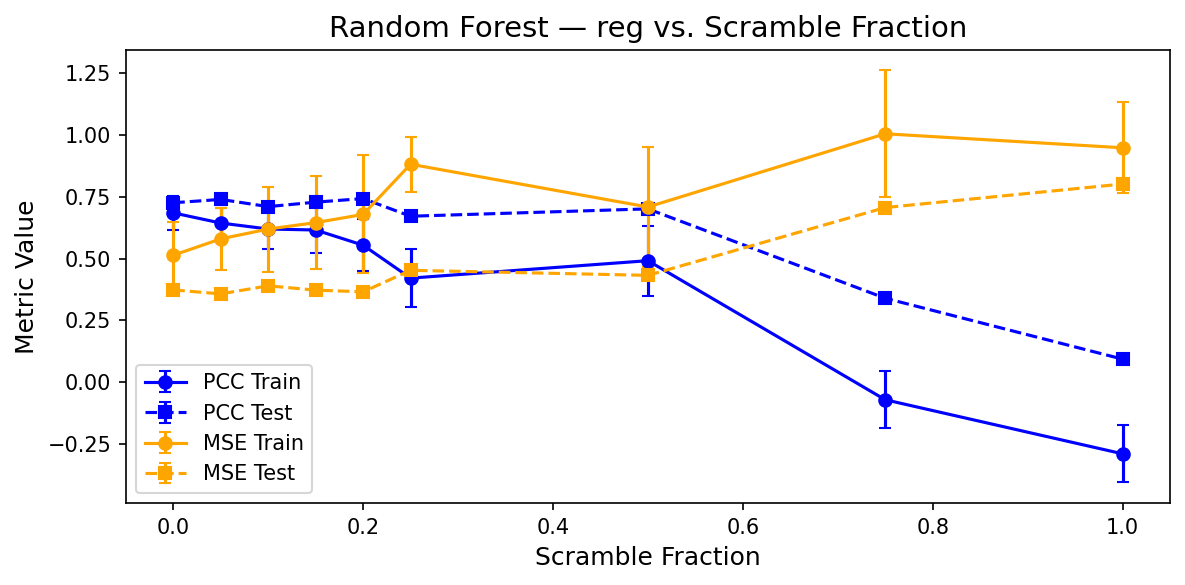

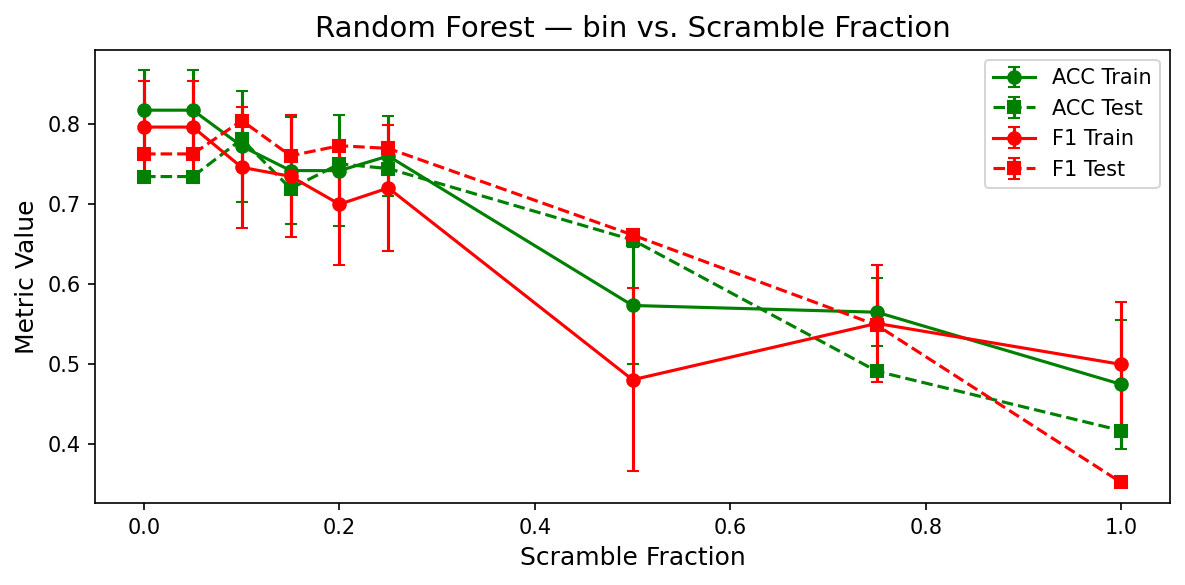

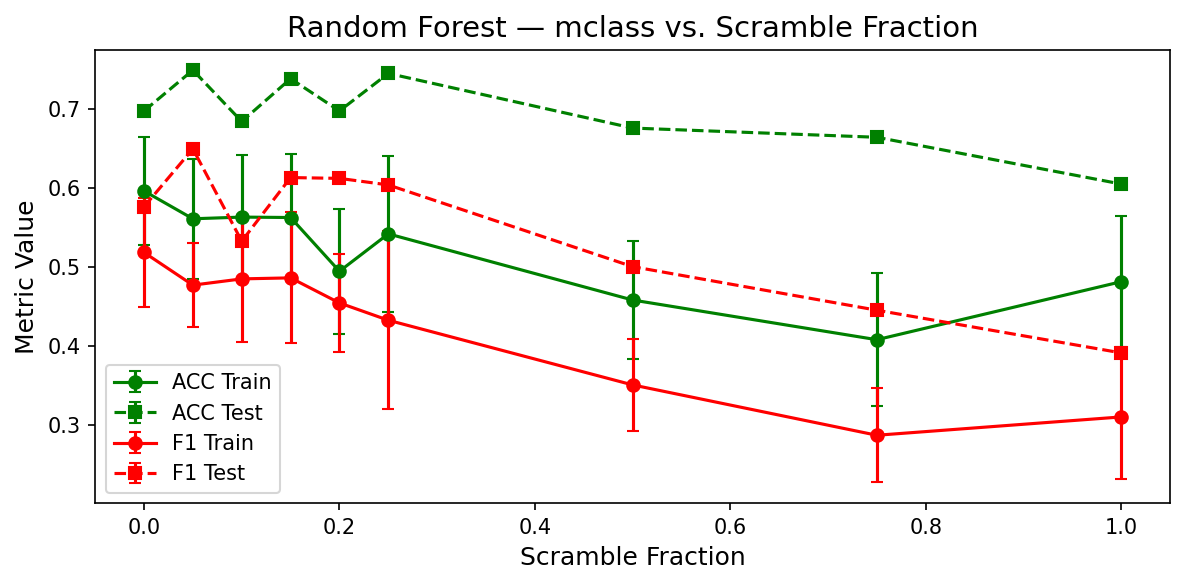

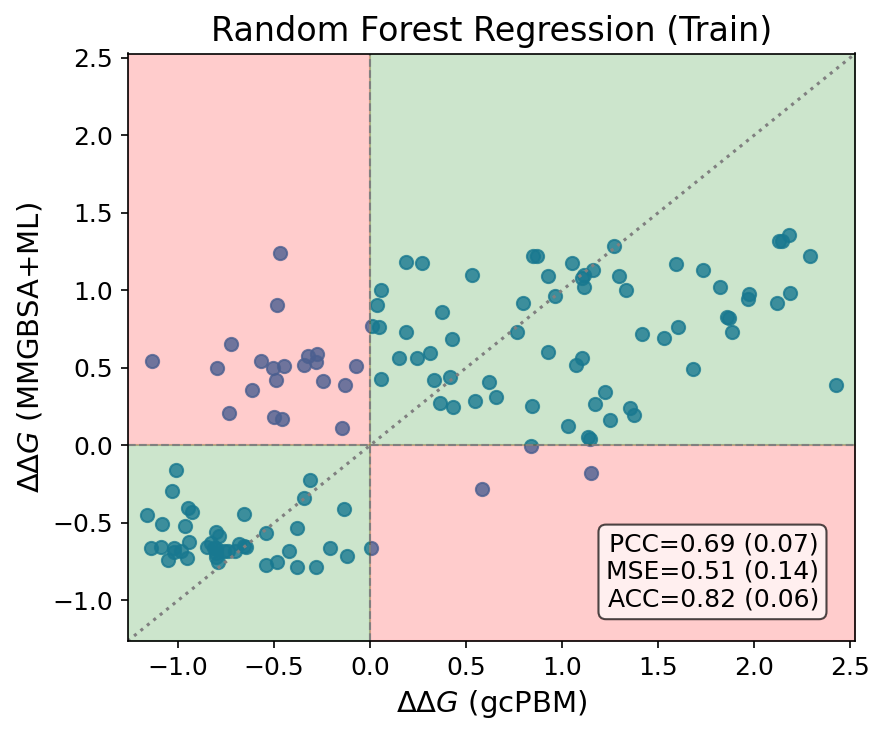

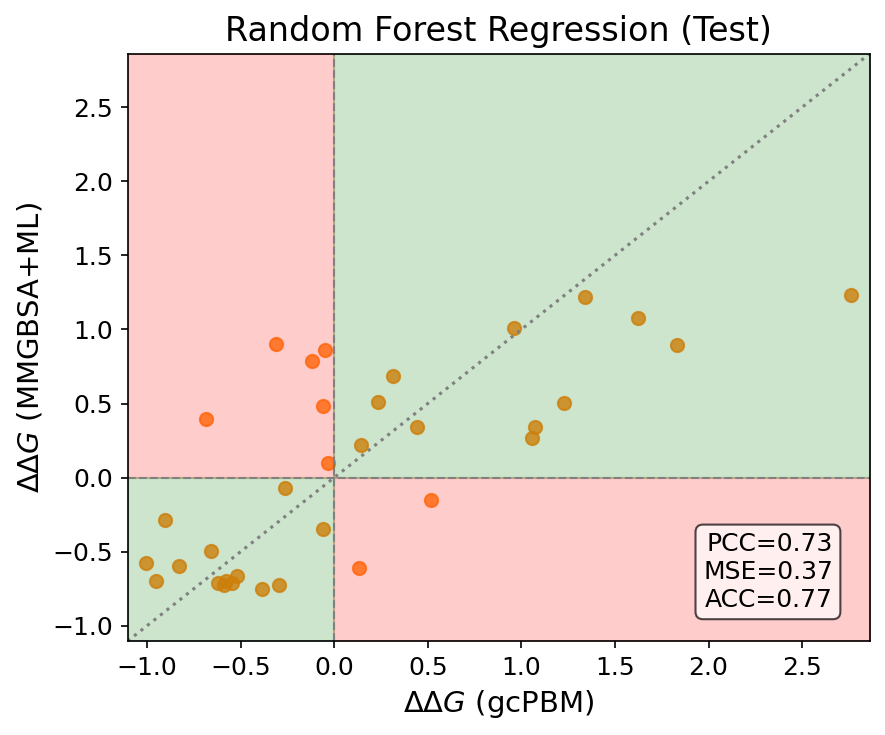

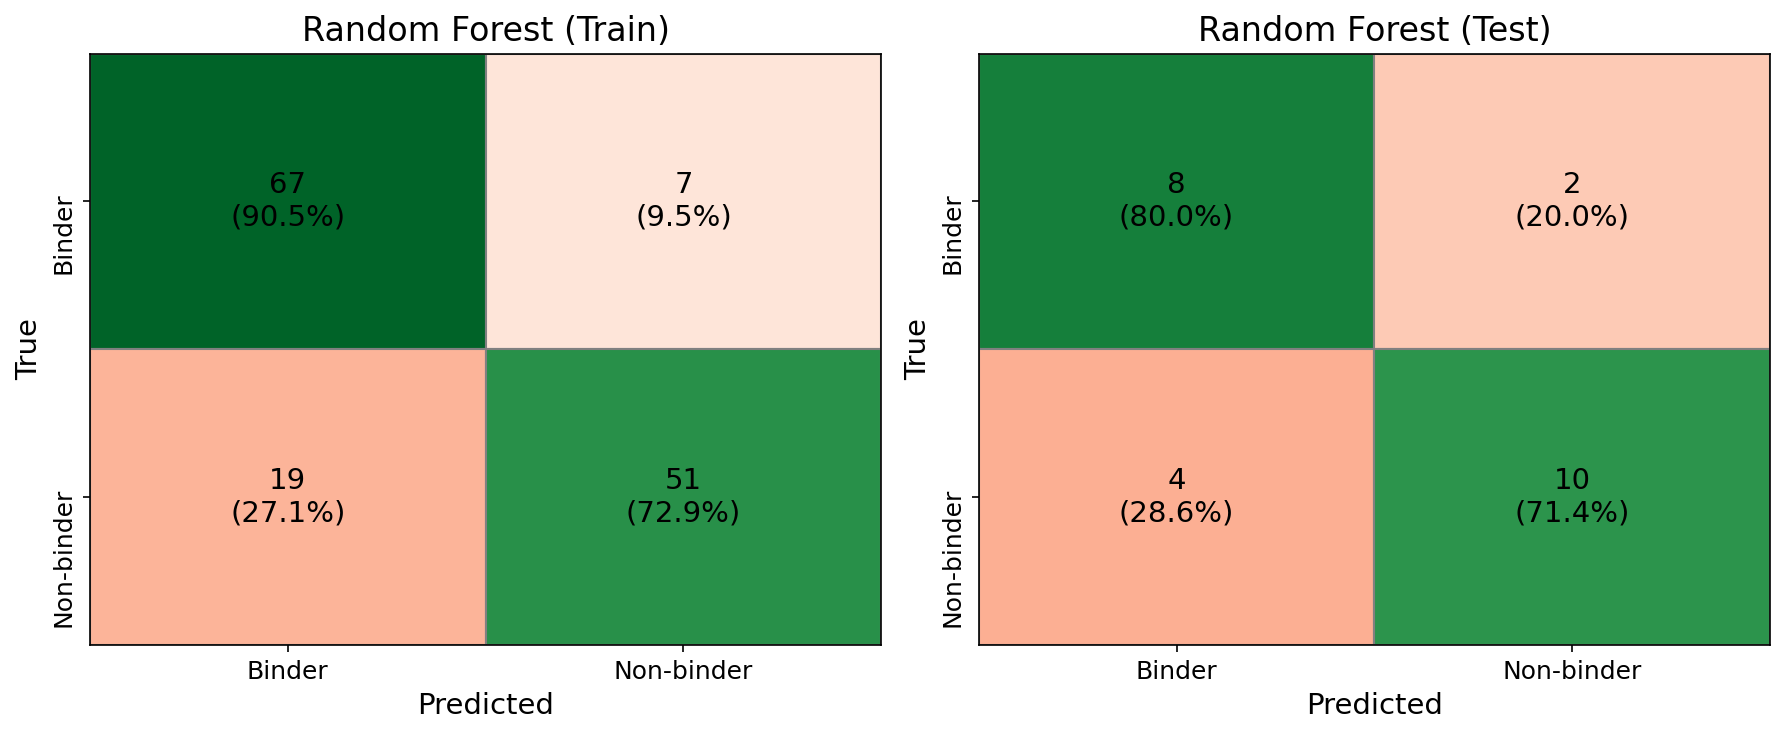

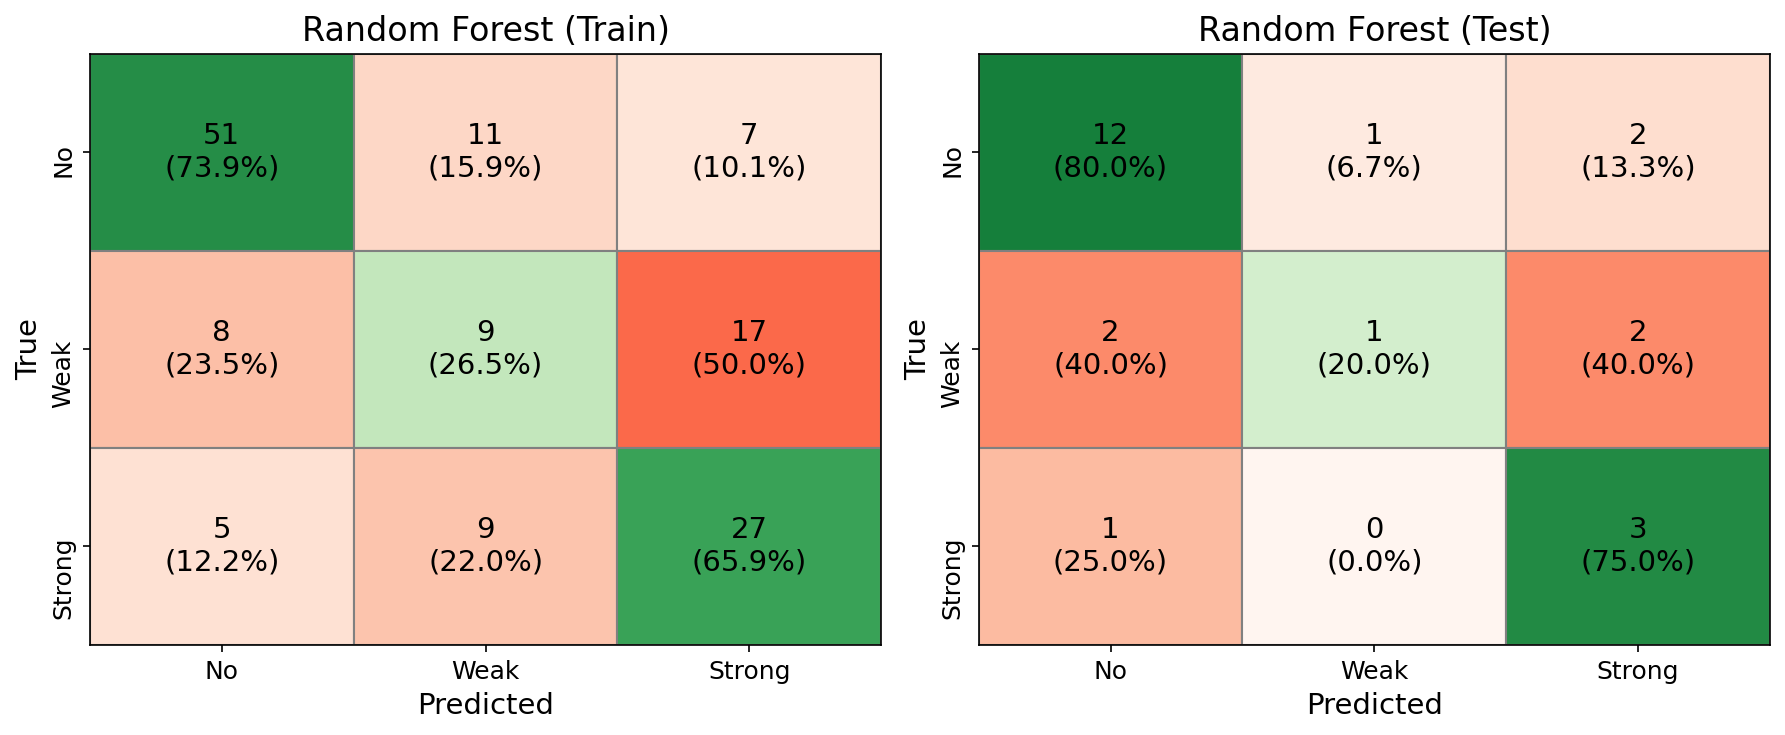

Model/rf_fold_*_reg_scr0p00.pkl


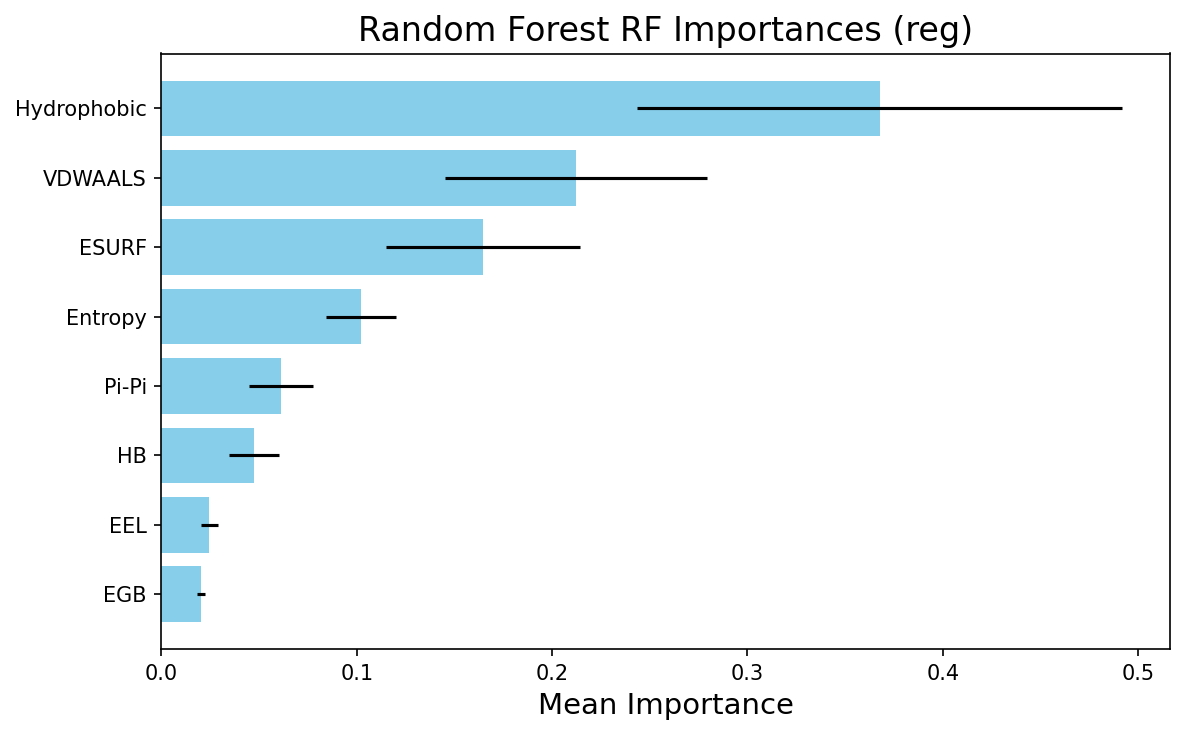

Model/rf_fold_*_bin_scr0p00.pkl


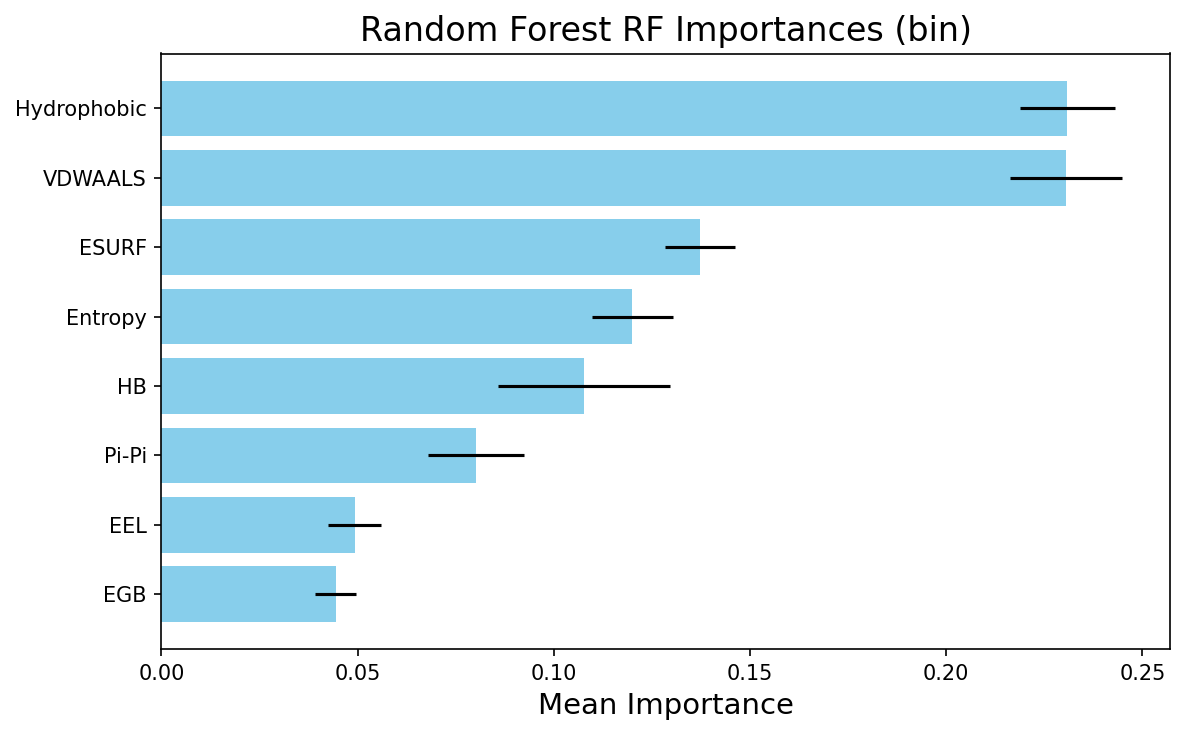

Model/rf_fold_*_mclass_scr0p00.pkl


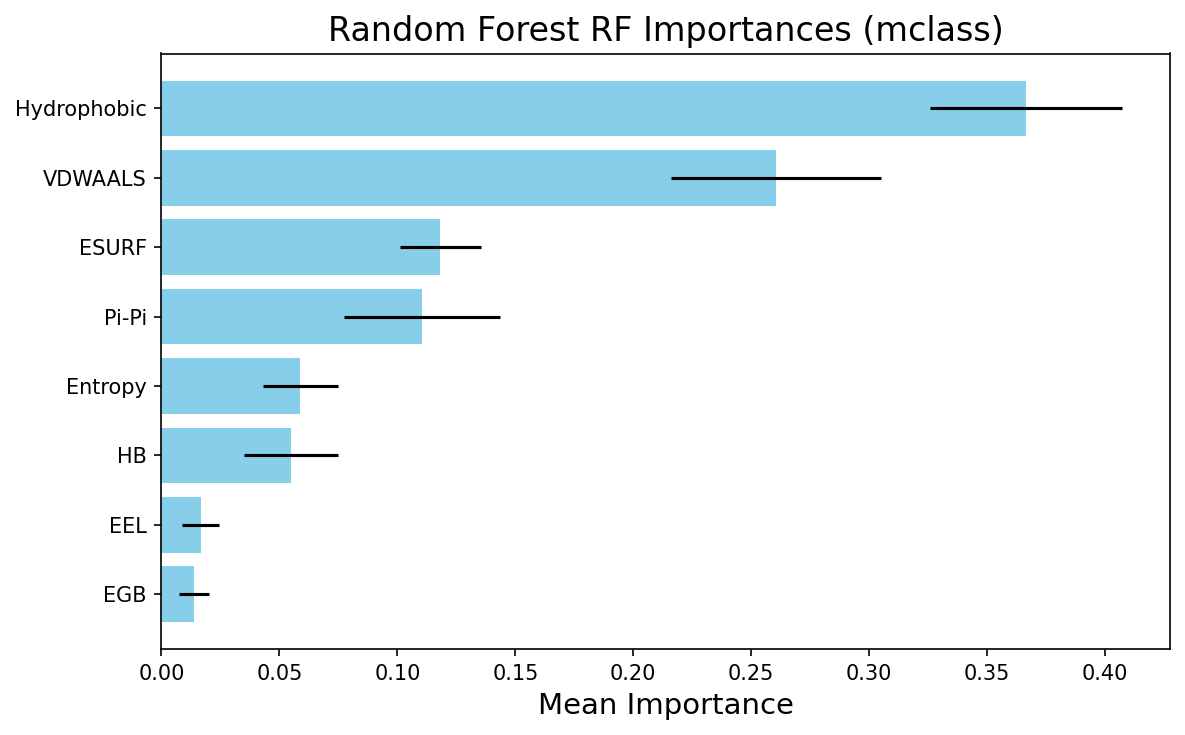

In [9]:
for name, folder in MODEL_CONFIGS.items():
    print(f"--- Processing {name} in {folder} ---")

    # 1) Collect prediction files
    df_reg, df_bin, df_mcl = collect_prediction_files(folder)
    
    # 2) Compute & save metrics summary
    summary = compute_metrics_across_folds(df_reg, df_bin, df_mcl, model_name=name)
    if summary is not None:
        out_csv = Path(folder)/(name.replace(" ","_")+"_metrics.csv")
        summary.to_csv(out_csv, index=False)
        print(f"Metrics saved to {out_csv}")

    # 3) Performance vs scramble fraction
    plot_metrics_vs_scramble(summary, model_name=name)

    # 4) Regression & Classification Plots
    plot_regression_quadrants(df_reg, summary, model_name=name)
    plot_binary_and_multiclass_cm(df_bin, df_mcl, model_name=name, scr_frac=0.0)
    
    # 5) RF feature importances (scr=0)
    if "random" in name.lower():
        plot_rf_importances(folder, name, FEATURES_BASE, model_type="reg", scr_frac=0.0)
        plot_rf_importances(folder, name, FEATURES_BASE, model_type="bin", scr_frac=0.0)
        plot_rf_importances(folder, name, FEATURES_BASE, model_type="mclass", scr_frac=0.0)
        

## Extra Analysis: Flanking Sequence Effects

Performs two analyses on the `df_reg` predictions at scramble fraction 0.00:

1. **`plot_regression_cacgtg_inset`**  
   - Plots True vs. Predicted binding affinities for all sequences.  
   - Highlights all probes whose central 6-mer is the canonical E-box `CACGTG` in red.  
   - Shades quadrants to indicate correct vs. incorrect predictions.  
   - Adds an inset showing mean±STD of True vs. Predicted for each unique `CACGTG`-centered sequence, along with its PCC and MSE.

2. **`plot_flank_boxplots`**  
   - Focuses on the same `CACGTG`-centered subset.  
   - Extracts the 1-, 2-, and 3-nt flanking bases around the motif.  
   - Draws horizontal boxplots of predicted affinities grouped by each flank combination, to gauge how flanking context alters predictions.

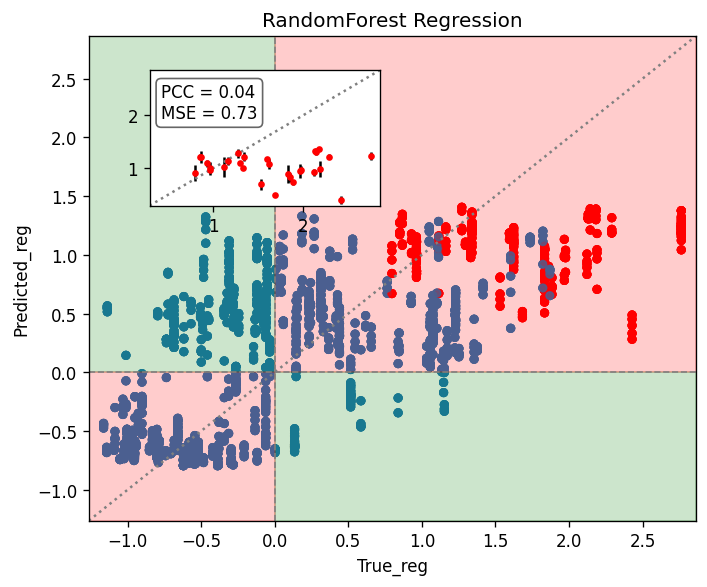

In [10]:
def plot_regression_cacgtg_inset(df, model_name="MyModel"):
    # Filter to scr_frac == 0.00
    df_0 = df[df["scr_frac"] == 0.00].copy()
    if df_0.empty:
        print("No regression data at scr_frac=0.00."); return
    
    # Mark CACGTG center (positions 15–21)
    df_0["is_cacgtg"] = df_0["Label"].apply(
        lambda s: isinstance(s,str) and len(s)>=21 and s[15:21]=="CACGTG"
    )
    
    # Main scatter
    fig, ax = plt.subplots(figsize=(6,5), dpi=120)
    ax.scatter(
        df_0["True_reg"], df_0["Predicted_reg"],
        s=20, alpha=0.8,
        color=df_0["is_cacgtg"].map({True:"red", False:"tab:blue"})
    )
    # diagonal & axes
    mn = min(df_0[["True_reg","Predicted_reg"]].min()) - 0.1
    mx = max(df_0[["True_reg","Predicted_reg"]].max()) + 0.1
    ax.plot([mn,mx],[mn,mx], ":", color="grey")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.axvline(0, color="grey", linestyle="--", linewidth=1)
    ax.set_xlim(mn,mx); ax.set_ylim(mn,mx)
    ax.set_title(f"{model_name} Regression"); ax.set_xlabel("True_reg"); ax.set_ylabel("Predicted_reg")
    # quadrant shading
    ax.fill_between([mn,0],[0,0],[mx,mx], color="green", alpha=0.2)
    ax.fill_between([0,mx],[mn,mn],[0,0], color="green", alpha=0.2)
    ax.fill_between([mn,0],[mn,mn],[0,0], color="red", alpha=0.2)
    ax.fill_between([0,mx],[0,0],[mx,mx], color="red", alpha=0.2)
    
    # Inset for CACGTG only
    df_cac = df_0[df_0["is_cacgtg"]]
    if not df_cac.empty:
        stats = df_cac.groupby("Label").agg({
            "True_reg":["mean","std"], "Predicted_reg":["mean","std"]
        }).reset_index()
        stats.columns = ["Label","Tmean","Tstd","Pmean","Pstd"]
        mse = mean_squared_error(df_cac["True_reg"], df_cac["Predicted_reg"])
        pcc = pearsonr(df_cac["True_reg"], df_cac["Predicted_reg"])[0]
        
        inset = ax.inset_axes([0.1,0.65,0.38,0.28])
        inset.errorbar(
            stats["Tmean"], stats["Pmean"],
            yerr=stats["Pstd"], fmt='.', color="red", ecolor="black"
        )
        # inset diagonal and axes
        cmin = min(stats[["Tmean","Pmean"]].min()) - 0.1
        cmax = max(stats[["Tmean","Pmean"]].max()) + 0.1
        inset.plot([cmin,cmax],[cmin,cmax], ":", color="grey")
        inset.axhline(0, color="grey", linestyle="--")
        inset.axvline(0, color="grey", linestyle="--")
        inset.set_xlim(cmin,cmax); inset.set_ylim(cmin,cmax)
        inset.text(
            0.05,0.9,
            f"PCC = {pcc:.2f}\nMSE = {mse:.2f}",
            transform=inset.transAxes,
            fontsize=10, va="top", ha="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.6)
        )
    plt.tight_layout()
    plt.show()

plot_regression_cacgtg_inset(df_reg, model_name="RandomForest")


/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_14505/3481657851.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cac[col] = df_cac["Label"].apply(lambda s: get_flank(s,n))
/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_14505/3481657851.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cac[col] = df_cac["Label"].apply(lambda s: get_flank(s,n))
/var/folders/jg/f84gjnc17d51qj6zy5cb71lh0000gq/T/ipykernel_14505/3481657851.py:18: SettingWithCopyWarning: 
A value is trying to b

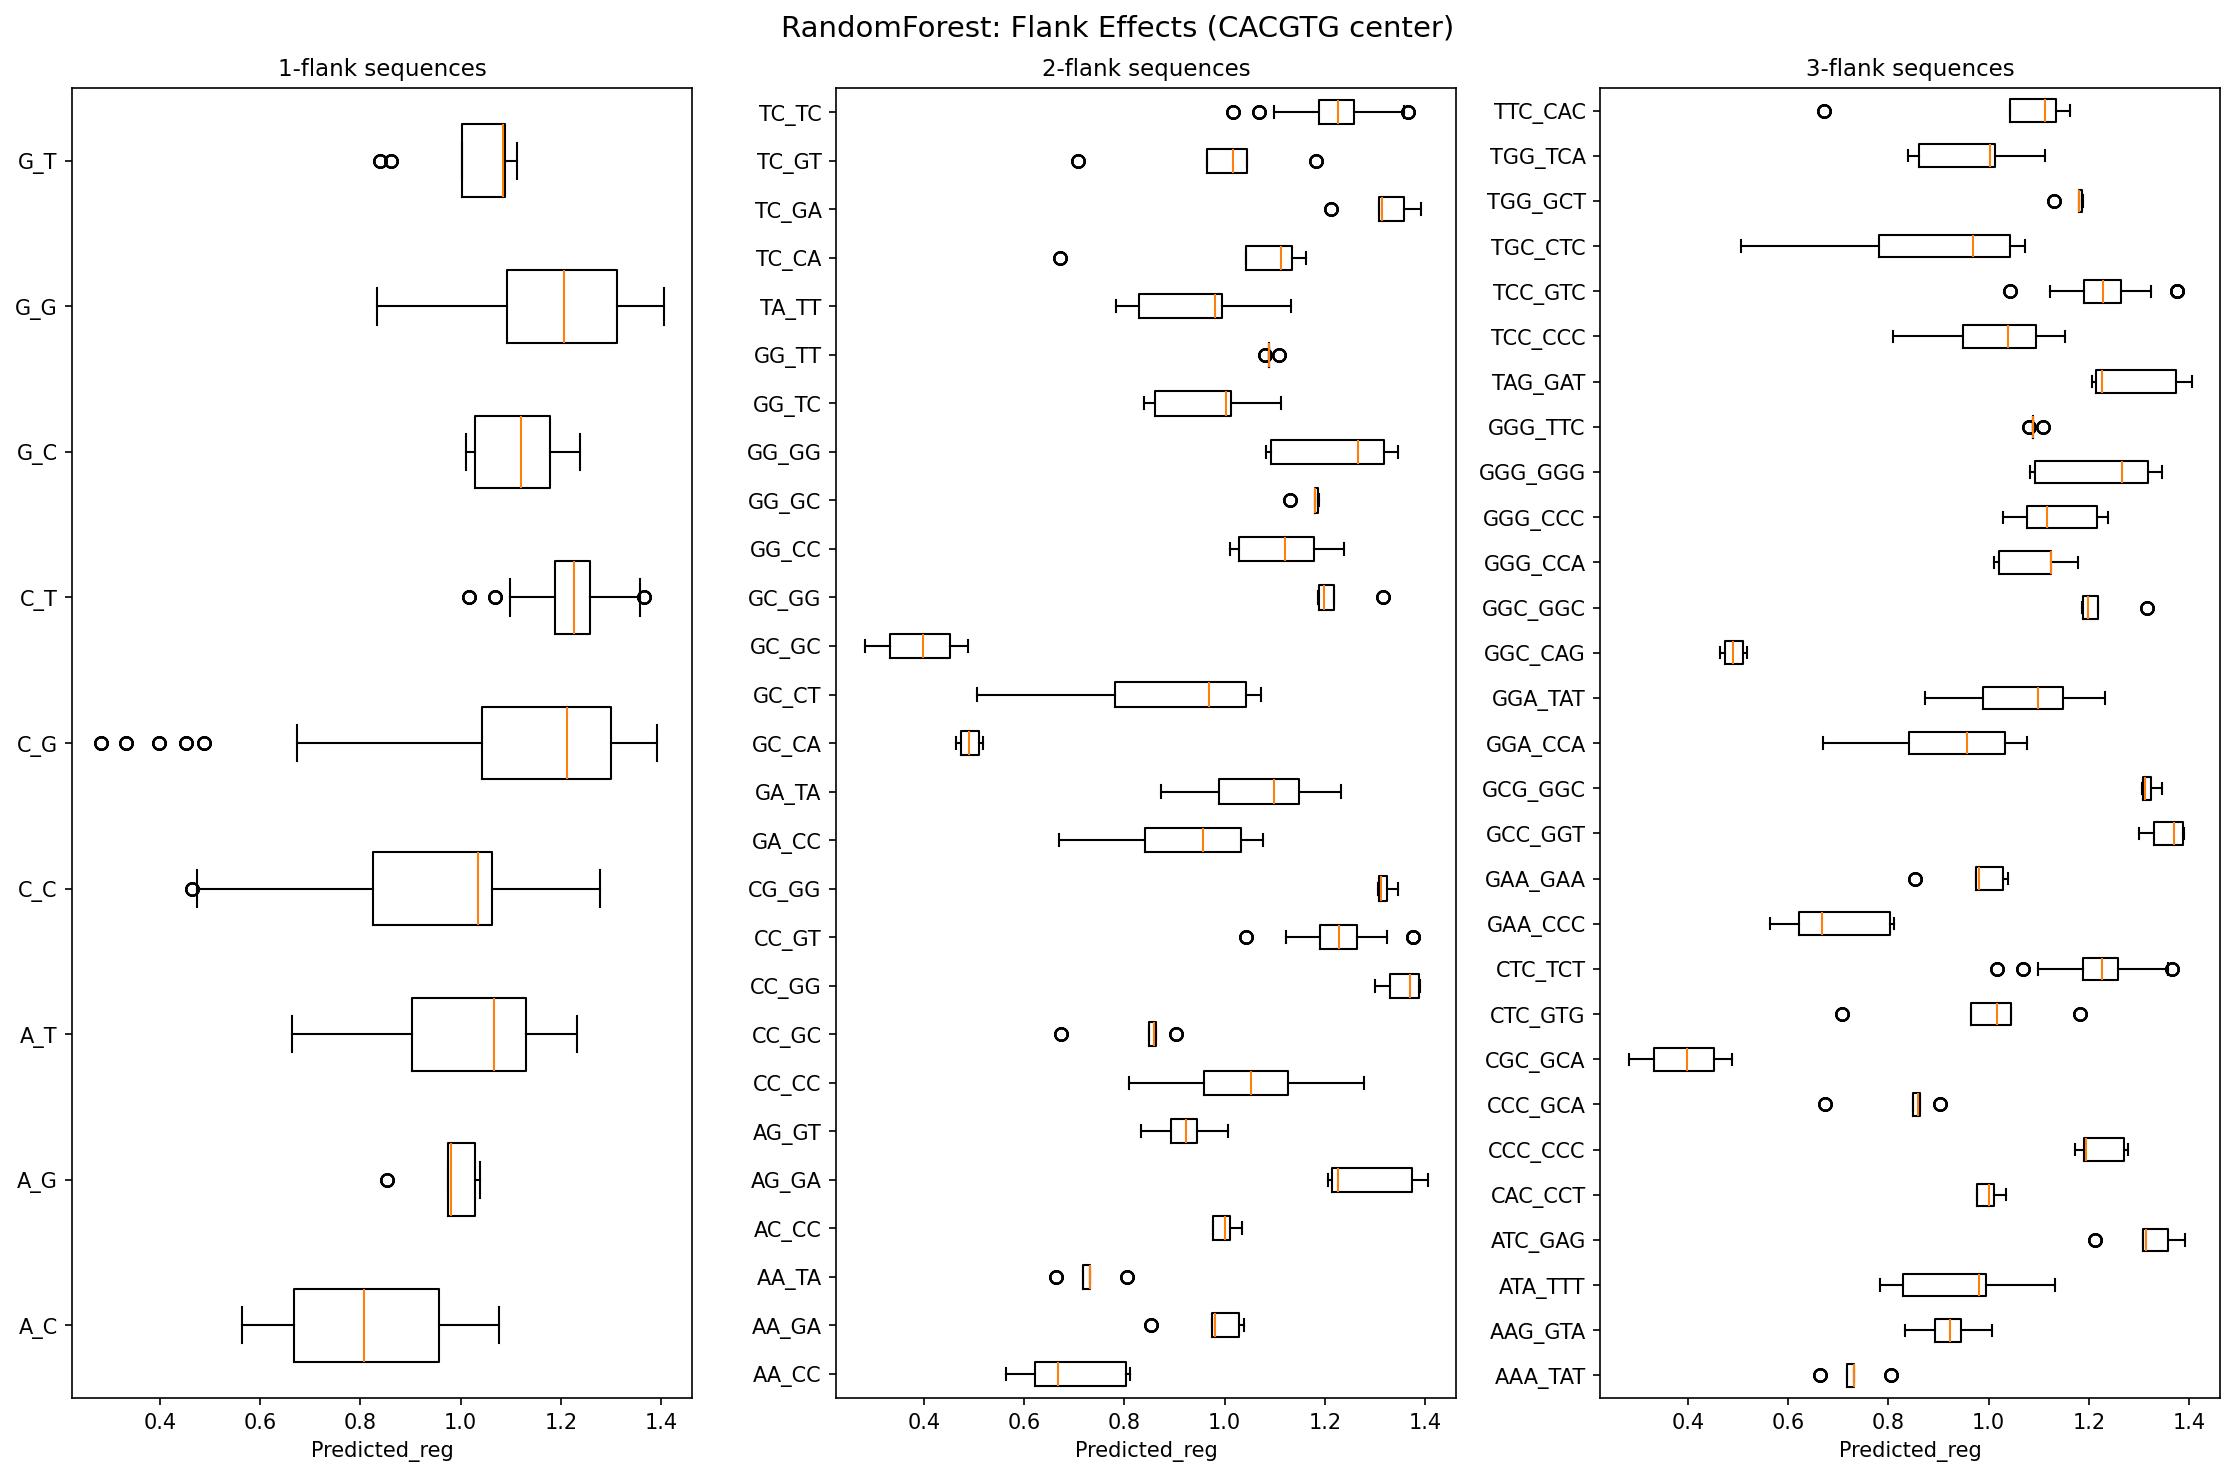

In [11]:
def plot_flank_boxplots(df, model_name="MyModel"):
    # Only scr_frac==0.00 + CACGTG center
    df0 = df[df["scr_frac"]==0.00].copy()
    df0["is_cacgtg"] = df0["Label"].apply(
        lambda s: isinstance(s,str) and len(s)>=21 and s[15:21]=="CACGTG"
    )
    df_cac = df0[df0["is_cacgtg"]]
    if df_cac.empty:
        print("No CACGTG sequences for flank analysis."); return
    
    # helper to extract n‐bp flanks
    def get_flank(seq,n):
        return seq[15-n:15] + "_" + seq[21:21+n]
    
    fig, axes = plt.subplots(1,3, figsize=(15,10), dpi=150, sharex=True)
    for i, n in enumerate([1,2,3]):
        col = f"flank_{n}"
        df_cac[col] = df_cac["Label"].apply(lambda s: get_flank(s,n))
        groups = df_cac.groupby(col)["Predicted_reg"].apply(list).tolist()
        labels = df_cac.groupby(col).groups.keys()
        axes[i].boxplot(groups, vert=False)
        axes[i].set_yticks(range(1,len(labels)+1))
        axes[i].set_yticklabels(labels, fontsize=10)
        axes[i].set_title(f"{n}-flank sequences", fontsize=11)
        axes[i].set_xlabel("Predicted_reg")
    fig.suptitle(f"{model_name}: Flank Effects (CACGTG center)", fontsize=14)
    plt.tight_layout()
    plt.show()


plot_flank_boxplots(df_reg, model_name="RandomForest")